In [31]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset
#from dummy import *
#from GCN_model import *

dtype = torch.long
batch_size = 128
learning_rate = 0.0001
num_epochs = 50
n_nodes = 10
hidden_dim = 10
n_classes = 4
dropout = 0.5

                           ###########################

def get_dataset(n_train=32768, n_valid=4096, n_nodes=20, n_classes=2, n_features=3):
    # Generate random adjacency matrices
    A = torch.randint(2, [n_train + n_valid, n_nodes, n_nodes])
    A = A.to(dtype)
    upper_tr = torch.triu(A, diagonal=1)
    data =  upper_tr + torch.transpose(upper_tr, 1, 2)
    # Generate train and validation data
    train_y = torch.sum(data[:n_train, :, :], dim=2)
    valid_y = torch.sum(data[n_train:, :, :], dim=2)
    train_y[train_y >= 1] = 1
    valid_y[valid_y >= 1] = 1
    data = torch.split(data, split_size_or_sections=[n_train, n_valid], dim=0)
    train_features = torch.randint(10, (n_train, n_nodes, n_features), dtype=dtype)
    valid_features = torch.randint(10, (n_valid, n_nodes, n_features), dtype=dtype)

    train_features = TensorDataset(train_features)
    valid_features = TensorDataset(valid_features)
    train_data = TensorDataset(data[0], train_y)
    valid_data = TensorDataset(data[1], valid_y)
    return train_data, valid_data, train_features, valid_features

                          ##############################  

def Normalize_Adj(A):
    A_tilda = A + torch.eye(A.shape[1]).repeat(A.shape[0], 1, 1)
    D_tilda = torch.diag_embed(torch.sum(A_tilda, 2).pow(-0.5))
    A_hat = D_tilda.bmm(A_tilda).bmm(D_tilda)
    return A_hat

class GraphConvolutionLayer(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.fc = nn.Linear(input_dim, output_dim, bias=False)
    torch.nn.init.xavier_uniform_(self.fc.weight)
  def forward(self, X, A):
    out = self.fc(X)
    out = torch.bmm(A, out)  
    return out

class TwoLayerGCN(nn.Module):
  def __init__(self, input_dim=5, hidden_dim=10, n_classes=4, dropout=0.5):
    super().__init__()
    self.gc1 = GraphConvolutionLayer(input_dim, hidden_dim)
    self.gc2 = GraphConvolutionLayer(hidden_dim, n_classes)
    self.dropout = dropout

  def forward(self, X, A):
    X = X.repeat(A.shape[0], 1, 1)
    #print('X: ', X.shape)
    out = self.gc1(X, Normalize_Adj(A))
    #print('Output after 1st GCN layer: ', out.shape)
    out = F.relu(out)
    out = F.dropout(out, self.dropout)
    out = self.gc2(out, Normalize_Adj(A))
    #print('Output after 2nd GCN layer: ', out.shape)
    #out = F.softmax(out) 
    return out

                               #########################################                          

train_dataset, valid_dataset, train_features, valid_features = get_dataset(n_nodes=n_nodes)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
X = torch.eye(n_nodes)

                             ##############

model = TwoLayerGCN(n_nodes, hidden_dim, n_classes, dropout)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

train_log = torch.zeros((num_epochs, 4), dtype=torch.float, requires_grad=False)

correct = 0
total = 0
for epoch in range(num_epochs):
    for i, (A, labels) in enumerate(train_loader):
        
        # Forward pass
        outputs = model(X, A)
        loss = criterion(outputs.transpose(1,2), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs,2)
        correct += (predicted == labels).sum()
        total += labels.numel()
        
    train_log[epoch, 0] = epoch
    train_log[epoch, 1] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))
    train_log[epoch, 2] = (100* correct / total)
    
    
with torch.no_grad():
    correct = 0
    total = 0
    for A, labels in valid_loader:
        outputs = model(X, A)
        _, predicted = torch.max(outputs, 2)
        total += labels.numel()
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))
    
train_log = train_log.detach().numpy()

Epoch [1/50], Loss: 1.3887
Epoch [2/50], Loss: 1.3482
Epoch [3/50], Loss: 1.3002
Epoch [4/50], Loss: 1.2462
Epoch [5/50], Loss: 1.1793
Epoch [6/50], Loss: 1.1063
Epoch [7/50], Loss: 1.0137
Epoch [8/50], Loss: 0.9004
Epoch [9/50], Loss: 0.7867
Epoch [10/50], Loss: 0.6793
Epoch [11/50], Loss: 0.5865
Epoch [12/50], Loss: 0.4831
Epoch [13/50], Loss: 0.4159
Epoch [14/50], Loss: 0.3410
Epoch [15/50], Loss: 0.2663
Epoch [16/50], Loss: 0.2400
Epoch [17/50], Loss: 0.1924
Epoch [18/50], Loss: 0.1507
Epoch [19/50], Loss: 0.1376
Epoch [20/50], Loss: 0.1243
Epoch [21/50], Loss: 0.1081
Epoch [22/50], Loss: 0.0767
Epoch [23/50], Loss: 0.0728
Epoch [24/50], Loss: 0.0617
Epoch [25/50], Loss: 0.0539
Epoch [26/50], Loss: 0.0406
Epoch [27/50], Loss: 0.0524
Epoch [28/50], Loss: 0.0542
Epoch [29/50], Loss: 0.0448
Epoch [30/50], Loss: 0.0307
Epoch [31/50], Loss: 0.0266
Epoch [32/50], Loss: 0.0428
Epoch [33/50], Loss: 0.0203
Epoch [34/50], Loss: 0.0421
Epoch [35/50], Loss: 0.0161
Epoch [36/50], Loss: 0.0239
E

[Text(63.125, 0.5, 'train_acc'), Text(0.5, 69.00000000000009, 'epochs')]

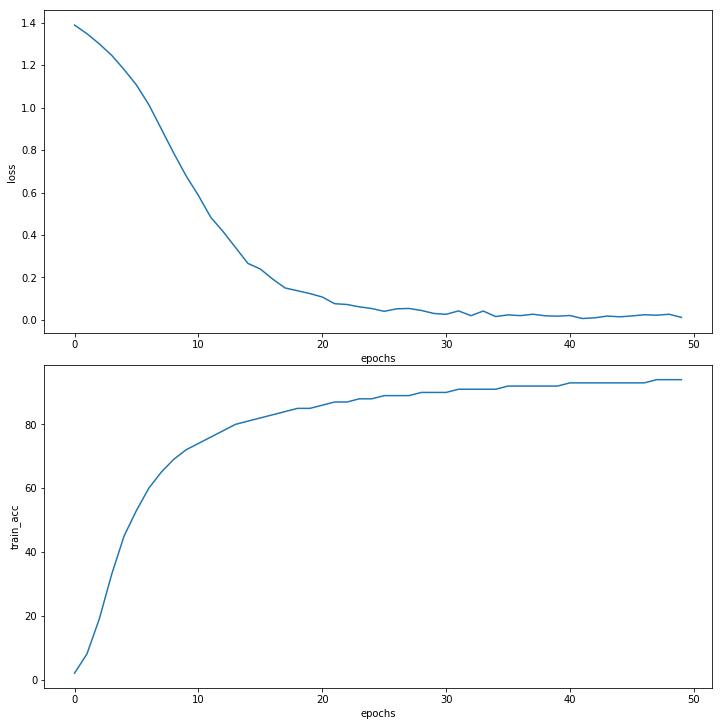

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout()

ax[0].plot(train_log[:,0], train_log[:,1])
ax[0].set(xlabel="epochs", ylabel="loss")

ax[1].plot(train_log[:,0], train_log[:,2])
ax[1].set(xlabel="epochs", ylabel="train_acc")